<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Single-qubit" data-toc-modified-id="Single-qubit-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Single qubit</a></span></li></ul></li><li><span><a href="#Test-using-propagator" data-toc-modified-id="Test-using-propagator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test using propagator</a></span></li><li><span><a href="#Evolve-using-master-equation-solver" data-toc-modified-id="Evolve-using-master-equation-solver-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Evolve using master equation solver</a></span><ul class="toc-item"><li><span><a href="#Extract-PTM" data-toc-modified-id="Extract-PTM-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extract PTM</a></span></li><li><span><a href="#Three-qubits" data-toc-modified-id="Three-qubits-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Three qubits</a></span></li></ul></li></ul></div>

# Preambles

In [23]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import scipy.linalg
from Fluxonium_hamiltonians import qchard_rotope as op
sys.path.append('/Users/longnguyen/Documents/GitHub/qtrl/')
from qtrl.benchmarking import tomography

## Single qubit

In [62]:
#Define qubit
wq = 5
H_nodrive = 0.5*wq*sigmaz()
H_drive = 0.5*sigmax()

#Define drive
wd=wq
T_gate = 50
shape = 'cos'
drive_freq = wq
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

#Decoherence
def c_ops_func(t1, t2):
    gamma1 = t1**(-1.0)
    gamma2 = t2**(-1.0)
    gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sigmam())
    c2 = np.sqrt(gamma_phi/2.0) *(sigmaz())
    return [c1, c2]

# Test using propagator

0.9999989675808049


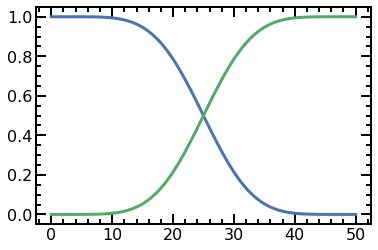

In [70]:
#Evolve using propagator
# c_ops = c_ops(1e3, 1e3)
U_ideal = sigmax()
state_0 = basis(2,0)
state_1 = basis(2,1)
P0 = state_0*state_0.dag()
P1 = state_1*state_1.dag()

H_dummy = 0.0*sigmax()
U_nothing = gates.evolution_operator_microwave(H_nodrive, H_dummy, t_points=t_points,T_gate=T_gate, shape=shape, omega_d=drive_freq, parallel = True)
U_t = gates.evolution_operator_microwave(-H_nodrive, H_drive, t_points=t_points,T_gate=T_gate, shape=shape, omega_d=drive_freq, parallel = True)

u0 = U_t[-1].matrix_element(state_0, state_0)
u1 = U_t[-1].matrix_element(state_1, state_1)

# phase = np.angle(u1/u0)
# single_qu_z = 0
# single_qu_z = single_qu_z + state_0*state_0.dag()
# single_qu_z = single_qu_z + np.exp(-1.0j*phase)*state_1*state_1.dag()
# U_real = single_qu_z*U_t[-1]
U_real = U_t[-1]
# U_real = U_nothing * U_t
# U_real = U_real[-1]
    
plt.plot(t_points, expect(P0,U_t*state_0))
plt.plot(t_points, expect(P1,U_t*state_0))

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print (fidel)

# Evolve using master equation solver

0.9915735991378194
0.9915735990966605


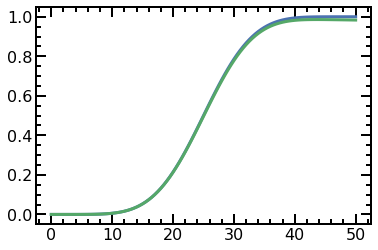

In [120]:
t1 = 2e3
t2 = 1e3
psi_ini = state_1
evol_states_ideal = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = [],
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_ideal))

evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_real))

rho_ideal = ket2dm(evol_states_ideal[-1])
rho_real = evol_states_real[-1]
print (qutip.fidelity(rho_ideal, rho_real))
fidel = (rho_real.sqrtm() * rho_ideal * rho_real.sqrtm()).sqrtm().tr()
print (abs(fidel))

## Extract PTM

/Users/longnguyen/Documents/GitHub/qtrl/qtrl/benchmarking/tomography.py:567: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pm = np.linalg.lstsq(p_out, p_in)[0]


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdfdda89ac0>)

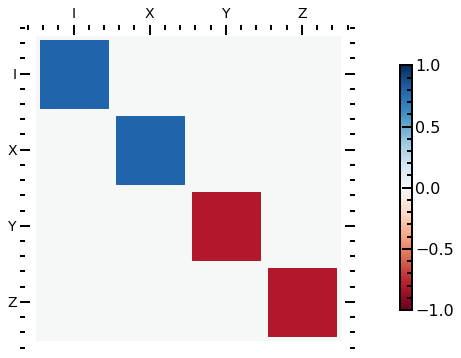

In [125]:
states_in = []
states_out = []
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 = psi_in, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
    
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    psi_out = np.array(evol_states[-1])
    states_out.append(psi_out)

ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)  

0.9999939878734401


/Users/longnguyen/Documents/GitHub/qtrl/qtrl/benchmarking/tomography.py:567: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pm = np.linalg.lstsq(p_out, p_in)[0]


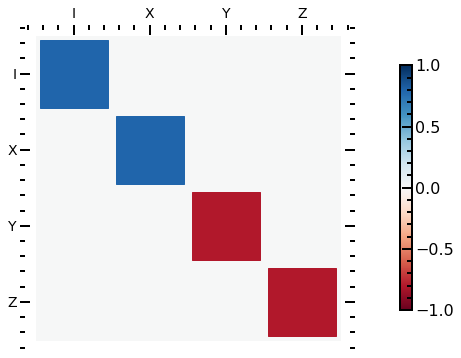

In [126]:
#Ideal case
gate = sigmax()
states_in = []
states_out = []
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    psi_out = np.array(ket2dm(gate*psi_in))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)

ptm_ideal = tomography.get_process_matrix(states_in, states_out, physical=True)
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)

print (tomography.process_fidelity(ptm_real, ptm_ideal))

In [ ]:
def get_process_matrix(states_in, states_out, physical=True):
    """
    Extract Pauli Transfer Matrix from measurements, described by input density matrices and output density-matrices
    :param states_in:   array-like, list of input density matrices
    :param states_out:  array-like, list of input density matrices
    :param physical     bool, whether to enforce physicality constraints on the Pauli Transfer Matrix
    :return:            matrix-like, Pauli transfer matrix based on input to output state mapping
    """
    n = int(np.log2(np.sqrt(len(states_in))))
    basis_str = list(map(''.join, product(*[["I", 'X', 'Y', 'Z']] * n)))
    orth_norm_herm_basis = {'I': np.eye(2),
                            'X': sigmax,
                            'Y': sigmay,
                            'Z': sigmaz}

    n_qubit_basis = []
    for base in basis_str:
        op_list = [orth_norm_herm_basis[k] for k in list(base)]
        n_qubit_basis.append(tensor(*op_list))
    n_qubit_basis = np.array(n_qubit_basis)
    # represent the input, output density matrices in the Pauli basis
    p_in = np.array([np.linalg.solve(n_qubit_basis.T.reshape(4 ** n, 4 ** n), x.reshape(-1)) for x in states_in])
    p_out = np.array([np.linalg.solve(n_qubit_basis.T.reshape(4 ** n, 4 ** n), x.reshape(-1)) for x in states_out])
    pm = np.linalg.lstsq(p_out, p_in)[0]
    if physical:  # whether to enforce physicality constraints on the Pauli Transfer Matrix
        choi_matrix = ptm_to_choi(pm)
        choi_physical = project_and_normalize_density_matrix(choi_matrix)
        pm_physical = choi_to_ptm(choi_physical)
        pm = pm_physical
    return pm

<ipython-input-86-cb473937e0d1>:1: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), rx(np.pi/2), ry(-np.pi/2), sigmax()]
<ipython-input-86-cb473937e0d1>:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real =  np.linalg.lstsq(p_out, p_in)[0]


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdffb83f1c0>)

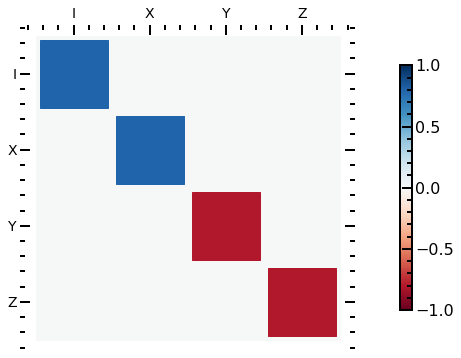

In [86]:
prep_ops = [qeye(2), rx(np.pi/2), ry(-np.pi/2), sigmax()]
meas_ops = [qeye(2), sigmax(), sigmay(), sigmaz()]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)

for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = expect(meas, psi_ini)
        p_out[i,j] = expect(meas, evol_states[-1])
        
ptm_real =  np.linalg.lstsq(p_out, p_in)[0]   

# Make physical
pm = ptm_real
choi_matrix = tomography.ptm_to_choi(pm)
choi_physical = tomography.project_and_normalize_density_matrix(choi_matrix)
pm_physical = tomography.choi_to_ptm(choi_physical)
ptm_real = pm_physical

op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)       

<ipython-input-87-d551d424cd15>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_ideal =  np.linalg.lstsq(p_out, p_in)[0]


0.9999992307179089


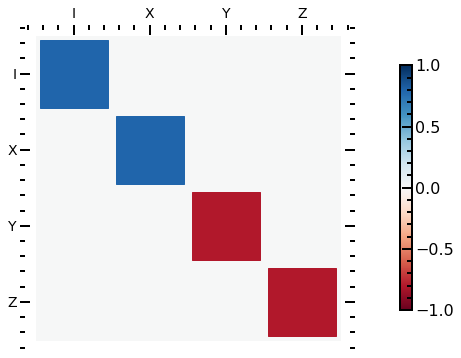

In [87]:
#Ideal PTM
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 = psi_ini, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                            T_gate=T_gate, shape=shape, omega_d=drive_freq)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = expect(meas, psi_ini)
        p_out[i,j] = expect(meas, sigmax() * psi_ini)
        
ptm_ideal =  np.linalg.lstsq(p_out, p_in)[0]  
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)  


print (tomography.process_fidelity(ptm_real, ptm_ideal))

In [7]:
t_coh = np.linspace(1e3, 10e3, 10)
fidel = np.zeros_like(t_coh)

for idx, t in enumerate(t_coh):
    c_ops = c_ops_func (10e6, t)
    overlap = 0
    for psi in psi_ini:
        evol_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0=psi, t=t_points,
                                                T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
        rho_ideal = ket2dm(evol_ideal)
        rho_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0=psi, t=t_points, c_ops= c_ops,
                                                T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
        overlap = overlap + (rho_real*rho_ideal).tr()
    fidel[idx] = abs(overlap)/6.0
    
gamma1 = 1.0/1e6
gamma2 = 1.0/t_coh
gamma_phi = gamma2 - gamma1/2.0
T_err = (gamma_phi+gamma1)**-1.0*3

Text(0.5, 1.0, 'SQG decoherence error')

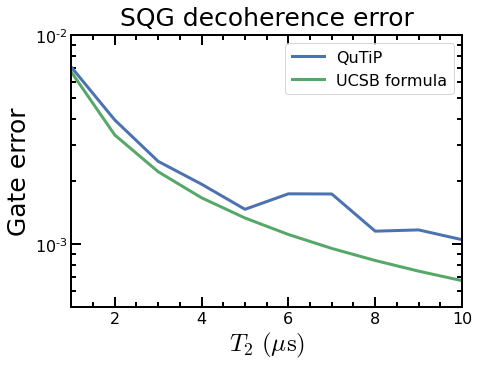

In [13]:
plt.figure(figsize = [7,5])
plt.semilogy(t_coh/1e3, 1-fidel, label = 'QuTiP')
plt.semilogy(t_coh/1e3, T_gate/T_err, label = 'UCSB formula')
# plt.semilogy(t_coh/1e3, T_gate/t_coh, label = r'$T_g/T_2$')
plt.xlabel(r'$T_2~(\mathrm{\mu s})$')
plt.ylabel('Gate error')
plt.ylim([5e-4,1e-2])
plt.xlim([t_coh[0]/1e3,t_coh[-1]/1e3])
plt.legend()
plt.title('SQG decoherence error')

## Three qubits

In [7]:
sz1 = tensor(sigmaz(), identity(2), identity(2))
sz2 = tensor(identity(2), sigmaz(), identity(2))
sz3 = tensor(identity(2), identity(2), sigmaz())
sx1 = tensor(sigmax(), identity(2), identity(2))
sx2 = tensor(identity(2), sigmax(), identity(2))
sx3 = tensor(identity(2), identity(2), sigmax())
sm1 = tensor(sigmam(), identity(2), identity(2))
sm2 = tensor(identity(2), sigmam(), identity(2))
sm3 = tensor(identity(2), identity(2), sigmam())
    
def toffoli_H_coupled(freq1, freq2, freq3, g):
    return (0.5*freq1*sz1 + 0.5*freq2*sz2 + 0.5*freq3*sz3 + g*sx1*sx2 + g*sx2*sx3)

def toffoli_collapse_ops(t1,t2):
    gamma1 = 1.0/t1
    gamma2 = 1.0/t2
    gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sm1 + sm2 + sm3)
    c2 = np.sqrt(gamma_phi/2.0) *(sz1 + sz2 + sz3)
    c_ops = [c1, c2]
    return c_ops

freq1 = 5.2541
freq2 = 5.331
freq3 = 5.491
g = 2.74 * 1e-3
T_gate = 340
shape = 'gauss'
drive_freq = freq2
drive_amp = 1
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_nodrive = toffoli_H_coupled(freq1, freq2, freq3, g)
H_drive = drive_amp*(sx1 + sx3)
psi0 = tensor(basis(2,0),basis(2,0),basis(2,0))

t1_toff = 50e3
t2_toff = 60e3
c_ops_toff = toffoli_collapse_ops(t1_toff,t2_toff)

Done


In [9]:
overlap = 0
for p1_idx in range(6):
    for p2_idx in range(6):
        for p3_idx in range(6):
            psi_ini = tensor(rotation[p1_idx], rotation[p2_idx], rotation[p2_idx])*psi0
            evol_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0=psi_ini, t=t_points,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            rho_ideal = ket2dm(evol_ideal)
            rho_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0=psi_ini, t=t_points, c_ops=c_ops_toff,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            overlap = overlap + (rho_real*rho_ideal).tr()
fidel = abs(overlap)/(6.0**3)
print (fidel)

0.9810469190641585


In [10]:
print (qutip.Options())

Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            1000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          8
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False

